In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, validation_curve, StratifiedKFold
from sklearn.svm import SVC
import numpy as np 
%matplotlib inline

#### Load porosity and permeability data

From Douglas Cant and Valerie Ethier (1984). 
Lithology-Dependent Diagenetic Control of Reservoir Properties of Conglomerates, Falher Member, Elmworth Field, Alberta. AAPG Bulletin, 68 (8), pages 1044-1054.  Data accessed through [USGS Open-file Report 03-420A](https://pubs.usgs.gov/of/2003/ofr-03-420/ofr-03-420.html): Catalogue of Porosity and Permeability from Core Plugs in Siliciclastic Rocks.

In [2]:
data = np.loadtxt('9-Cant&Ethier-1994.txt', skiprows = 1, usecols=(0,1,2,3))

#### Split into feature and target variables

In [3]:
X = [[poro, perm] for poro, perm in zip(data[:-1,0], data[:-1,1])]
y = data[:-1,3]

#X = [[poro, perm] for poro, perm in zip(data[:,0], data[:,1])]
#y = data[:,3]

#### Make accuracy scorer for crossvalidation

In [4]:
Ascorer = make_scorer(accuracy_score)

#### Create model with RBF kernel, train with k-fold cv, find optimal parameters with grid search

In [5]:
clf = SVC(kernel = 'rbf')

skf = StratifiedKFold(n_splits=12)  # stratified k-fold ensures balanced classes
                                    # because there are not a lot of points I want a high cv,
                                    # in this case, n_splits
                                    # (n_splits= 16 would be LOOCV 
                                    # because there are 17 samples in class 2)

C_range = np.array([ 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 400])
gamma_range = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 10., 100.])


param_grid = dict(gamma=gamma_range, C=C_range)

grid_search = GridSearchCV(clf,
                           param_grid=param_grid,
                           scoring = Ascorer, 
                           n_jobs = -1, cv = skf)
            
grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_


Best score: 0.833333333333
Best parameters: {'C': 5.0, 'gamma': 0.10000000000000001}


SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [6]:
scores = grid_search.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

#### Display grid search results as a heat map

Define a utility function to move the midpoint of a colormap to be around the values of interest. [From this scikit-learn example](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

In [7]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [8]:
plt.rcParams.update({'font.size': 17})

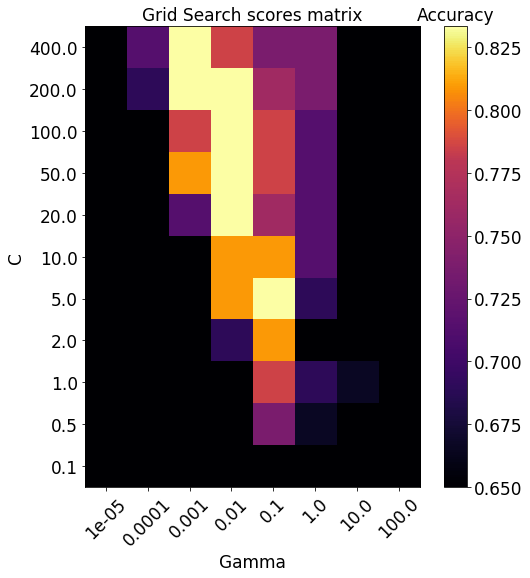

In [9]:
fig = plt.figure(figsize=(9, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.inferno, norm=MidpointNormalize(vmin=0.65, midpoint=0.78))
plt.xlabel('Gamma', fontsize = 17)
plt.ylabel('C', fontsize = 17)


clb = plt.colorbar()
clb.ax.set_title('Accuracy', fontsize = 17)

plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Grid Search scores matrix', fontsize = 17)

plt.ylim(plt.ylim()[::-1]) 

fig.savefig('gs_poro-perm.png', dpi=400, bbox_inches='tight', pad_inches=0.4)
plt.show()


#### Fit all data to final model  (optimal C, Gamma parameters, and kernel)

In [10]:
clf_rep = SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
clf_rep.fit(X,y)
y_pred = clf_rep.predict(X)

#### Print classification report

In [12]:
import re
from io import StringIO
def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
    return(report_df)

In [13]:
from sklearn.metrics import classification_report
print classification_report(y, y_pred, target_names = ['Sandstone', 'Conglomerate'])


              precision    recall  f1-score   support

   Sandstone       1.00      0.85      0.92        26
Conglomerate       0.80      1.00      0.89        16

 avg / total       0.92      0.90      0.91        42

